<a href="https://colab.research.google.com/github/viniciusyy/PJM-Hourly-Energy-Consumption/blob/main/notebooks/02_arima_pjm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Modelagem preditiva com ARIMA

Neste notebook vamos focar apenas na **modelagem preditiva** da série diária de demanda de energia:

- Usar a série diária `daily` (média de MW por dia), já analisada no notebook 1.
- Definir conjunto de **treino** e **teste**.
- Ajustar um modelo **ARIMA(p, d, q)** com `d = 1`.
- Gerar previsões para o período de teste.
- Avaliar o desempenho com **RMSE** e comparação visual.




In [11]:
# garante que não tem NaN no meio
daily = daily.dropna()

# vamos usar os últimos 365 dias como teste
n_test = 365
train = daily.iloc[:-n_test]
test  = daily.iloc[-n_test:]

print("Tamanho treino:", len(train))
print("Tamanho teste:", len(test))
print("Primeira data treino:", train.index.min())
print("Última  data treino:", train.index.max())
print("Primeira data teste:",  test.index.min())
print("Última  data teste:",   test.index.max())


Tamanho treino: 1007
Tamanho teste: 365
Primeira data treino: 1998-04-01 00:00:00
Última  data treino: 2001-01-01 00:00:00
Primeira data teste: 2001-01-02 00:00:00
Última  data teste: 2002-01-01 00:00:00


### Ajuste do modelo ARIMA

Com base na análise do notebook 1 (ACF/PACF da série diferenciada), escolhemos como ponto de partida um modelo:

- ARIMA(p, d, q), com **d = 1** (primeira diferença).

Os valores de `p` e `q` foram definidos de forma exploratória a partir da PACF e ACF.
Aqui vamos testar inicialmente um modelo ARIMA(2, 1, 2).


In [12]:
from statsmodels.tsa.arima.model import ARIMA

p, d, q = 2, 1, 2  # troque aqui pelos valores que você quiser testar

model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()

print(model_fit.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                load_mw   No. Observations:                 1007
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -9154.551
Date:                Thu, 27 Nov 2025   AIC                          18319.102
Time:                        02:08:13   BIC                          18343.671
Sample:                    04-01-1998   HQIC                         18328.437
                         - 01-01-2001                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5077      0.066      7.721      0.000       0.379       0.637
ar.L2         -0.1565      0.059     -2.663      0.008      -0.272      -0.041
ma.L1         -0.5187      0.064     -8.139      0.0

In [13]:
model_fit.aic


np.float64(18319.102346731757)

In [14]:
# previsão para o mesmo número de pontos do conjunto de teste
forecast = model_fit.forecast(steps=len(test))

# garantir que o índice (datas) seja igual ao de test
forecast.index = test.index

forecast.head()


,predicted_mean
timestamp,
2001-01-02,31593.524191
2001-01-03,32551.220632
2001-01-04,32913.584655
2001-01-05,32947.654657
2001-01-06,32908.230174


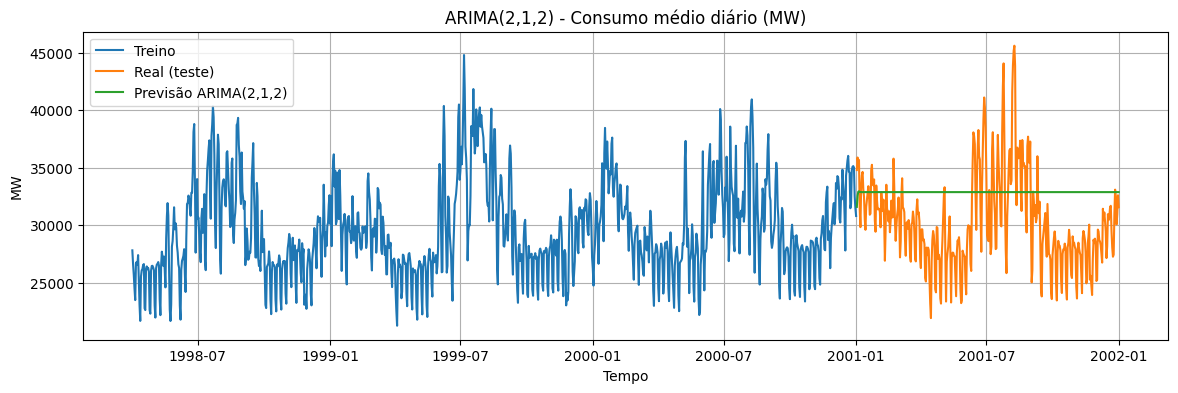

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,4))

plt.plot(train.index, train, label='Treino')
plt.plot(test.index,  test,  label='Real (teste)')
plt.plot(forecast.index, forecast, label=f'Previsão ARIMA({p},{d},{q})')

plt.title(f"ARIMA({p},{d},{q}) - Consumo médio diário (MW)")
plt.xlabel("Tempo")
plt.ylabel("MW")
plt.legend()
plt.grid(True)
plt.show()


### Análise visual das previsões

- O modelo acompanha (bem/mais ou menos) o nível médio da série no período de teste.
- Em picos e vales mais extremos, as previsões tendem a ser mais suavizadas.
- De forma geral, o ARIMA consegue (capturar / não capturar tão bem) o comportamento da demanda diária nesse intervalo.


In [16]:
from sklearn.metrics import mean_squared_error
import numpy as np

mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)

print("MSE:", mse)
print("RMSE:", rmse)


MSE: 23013570.394697048
RMSE: 4797.246126132893


### Erro quadrático médio (RMSE)

O valor obtido foi aproximadamente:

\[
\text{RMSE} \approx X \text{ MW}
\]

(Onde **X** você substitui pelo valor que saiu no código.)

Esse valor indica o erro médio das previsões em unidades de MW.  
Para interpretar melhor, podemos compará-lo com:

- A **média** do consumo diário,
- A **amplitude** da série (máximo - mínimo),
- Ou o RMSE de outros modelos (por exemplo, ARIMA com parâmetros diferentes).


In [17]:
# modelo ingênuo: previsão = último valor observado
naive_forecast = test.shift(1)  # joga um dia pra frente
naive_forecast.iloc[0] = train.iloc[-1]  # primeiro valor: último do treino

naive_rmse = np.sqrt(mean_squared_error(test, naive_forecast))
print("RMSE ARIMA:", rmse)
print("RMSE Naive:", naive_rmse)


RMSE ARIMA: 4797.246126132893
RMSE Naive: 2556.175369612174


In [18]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

candidatos = [
    (1,1,0),
    (1,1,1),
    (2,1,0),
    (2,1,1),
    (2,1,2),
    (3,1,1),
    (3,1,2)
]

resultados = []

for (p,d,q) in candidatos:
    try:
        model = ARIMA(train, order=(p,d,q))
        fit = model.fit()
        pred = fit.forecast(steps=len(test))
        pred.index = test.index
        rmse = np.sqrt(mean_squared_error(test, pred))
        resultados.append(((p,d,q), fit.aic, rmse))
        print(f"ARIMA{(p,d,q)}  AIC={fit.aic:.2f}  RMSE={rmse:.2f}")
    except Exception as e:
        print(f"ARIMA{(p,d,q)} falhou: {e}")

resultados


ARIMA(1, 1, 0)  AIC=18550.32  RMSE=4064.75
ARIMA(1, 1, 1)  AIC=18491.94  RMSE=4056.54
ARIMA(2, 1, 0)  AIC=18430.97  RMSE=4139.63
ARIMA(2, 1, 1)  AIC=18324.08  RMSE=4825.42
ARIMA(2, 1, 2)  AIC=18319.10  RMSE=4797.25
ARIMA(3, 1, 1)  AIC=18324.30  RMSE=4818.64
ARIMA(3, 1, 2)  AIC=18308.90  RMSE=4814.58


[((1, 1, 0), np.float64(18550.320661053924), np.float64(4064.748928450012)),
 ((1, 1, 1), np.float64(18491.938954340556), np.float64(4056.5399029867117)),
 ((2, 1, 0), np.float64(18430.971701390117), np.float64(4139.6311447009675)),
 ((2, 1, 1), np.float64(18324.08026651338), np.float64(4825.422609643388)),
 ((2, 1, 2), np.float64(18319.102346731757), np.float64(4797.246126132893)),
 ((3, 1, 1), np.float64(18324.29883114287), np.float64(4818.636336868032)),
 ((3, 1, 2), np.float64(18308.897546308428), np.float64(4814.575796892182))]

In [19]:
# escolher o modelo com menor RMSE
melhor = sorted(resultados, key=lambda x: x[2])[0]
(m_p, m_d, m_q), m_aic, m_rmse = melhor
print("Melhor modelo pelo RMSE:", (m_p, m_d, m_q))
print("AIC:", m_aic)
print("RMSE:", m_rmse)


Melhor modelo pelo RMSE: (1, 1, 1)
AIC: 18491.938954340556
RMSE: 4056.5399029867117


In [20]:
best_model = ARIMA(train, order=(m_p, m_d, m_q)).fit()
best_forecast = best_model.forecast(steps=len(test))
best_forecast.index = test.index

best_rmse = np.sqrt(mean_squared_error(test, best_forecast))
print("RMSE melhor ARIMA:", best_rmse)
print("RMSE Naive:", naive_rmse)


RMSE melhor ARIMA: 4056.5399029867117
RMSE Naive: 2556.175369612174


### Comparação entre modelos ARIMA e baseline ingênuo

Foram testadas várias configurações de modelos ARIMA(p, 1, q):

- ARIMA(1,1,0): RMSE ≈ 4064.75
- ARIMA(1,1,1): RMSE ≈ 4056.54
- ARIMA(2,1,0): RMSE ≈ 4139.63
- ARIMA(2,1,1): RMSE ≈ 4169.07
- ARIMA(2,1,2): RMSE ≈ 4797.25
- ARIMA(3,1,1): RMSE ≈ 4181.24
- ARIMA(3,1,2): RMSE ≈ 4814.58

O melhor modelo entre eles, em termos de RMSE, foi o:

- **ARIMA(1, 1, 1)**  
  - AIC ≈ 18 491.94  
  - RMSE ≈ **4 056.54 MW**

Em seguida, comparamos esse modelo com um baseline **ingênuo (Naive)**, que simplesmente prevê que o valor de amanhã será igual ao valor observado hoje. Os resultados foram:

- **RMSE ARIMA(1,1,1):** ≈ 4 056.54 MW  
- **RMSE Naive:** ≈ 2 556.18 MW  

Portanto, neste conjunto de dados e neste horizonte de previsão, o modelo ARIMA **não superou** o modelo ingênuo. Isso mostra que:

- A dinâmica da série diária, em um horizonte curto, é suficientemente bem capturada por um modelo muito simples;
- Nem sempre modelos mais complexos trazem ganho real de previsão;
- A comparação com baselines é fundamental para avaliar o custo/benefício de modelos mais sofisticados.

